In [1]:
library(randomForest())
library(caret)
library(ggplot2)
library(Metrics)
library(reshape2)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice


Attaching package: 'Metrics'


The following objects are masked from 'package:caret':

    precision, recall




In [2]:
df <- read.csv("../../../Cleaned Datasets R/rebate_cleaned.csv")
set.seed(42)

train_index <- createDataPartition(df$`Rebate.Amount..USD.`, p = 0.7, list = FALSE)

train_data <- df[train_index, ]
test_data <- df[-train_index, ]

train_data$`Rebate.Amount..USD.` <- factor(train_data$`Rebate.Amount..USD.`)
test_data$`Rebate.Amount..USD.` <- factor(test_data$`Rebate.Amount..USD.`)

In [3]:
set.seed(42)

num_predictors <- length(names(train_data)) - 1
mtry_sqrt <- floor(sqrt(num_predictors))

model <- randomForest(`Rebate.Amount..USD.`  ~ ., data = train_data, ntree = 30, 
            mtry = mtry_sqrt, nodesize=1, maxnodes=15, do.trace=TRUE)

print(model)
summary(model)

ntree      OOB      1      2      3      4
    1:   4.23% 16.57%  0.16%  7.94%  2.70%
    2:   3.70% 14.90%  0.12%  7.70%  1.63%
    3:   3.38% 13.20%  0.10%  7.97%  1.03%
    4:   3.32% 13.00%  0.13%  7.63%  1.12%
    5:   3.23% 13.07%  0.12%  7.25%  1.02%
    6:   3.49% 16.36%  0.11%  6.67%  1.13%
    7:   3.48% 16.06%  0.41%  6.33%  1.01%
    8:   3.69% 18.41%  0.37%  6.17%  0.97%
    9:   3.30% 16.31%  0.29%  5.28%  1.14%
   10:   2.97% 13.56%  0.18%  5.07%  1.38%
   11:   3.27% 15.58%  0.15%  5.02%  1.73%
   12:   3.05% 14.71%  0.15%  4.58%  1.62%
   13:   2.99% 13.97%  0.15%  4.84%  1.50%
   14:   3.14% 15.33%  0.18%  4.92%  1.41%
   15:   3.07% 15.11%  0.14%  5.04%  1.21%
   16:   3.05% 15.39%  0.15%  4.86%  1.17%
   17:   2.99% 15.50%  0.12%  4.58%  1.15%
   18:   2.92% 15.05%  0.12%  4.58%  1.08%
   19:   2.84% 14.48%  0.12%  4.55%  1.04%
   20:   2.93% 15.45%  0.12%  4.52%  1.02%
   21:   2.85% 15.67%  0.12%  4.04%  0.97%
   22:   2.84% 15.05%  0.12%  4.37%  0.95%
   23:   3.

                Length Class  Mode     
call                8  -none- call     
type                1  -none- character
predicted       16223  factor numeric  
err.rate          150  -none- numeric  
confusion          20  -none- numeric  
votes           64892  matrix numeric  
oob.times       16223  -none- numeric  
classes             4  -none- character
importance          9  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               16223  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

In [4]:
predictions <- predict(model, test_data)
actual <- test_data$`Rebate.Amount..USD.`

In [5]:
conf_matrix <- confusionMatrix(predictions, actual)

predictions <- factor(predictions, levels = levels(test_data$`Rebate.Amount..USD.`))

cm <- confusionMatrix(predictions, test_data$`Rebate.Amount..USD.`)

precision <- cm$byClass[, 'Precision']
recall <- cm$byClass[, 'Recall']
f1 <- cm$byClass[, 'F1']
accuracy <- cm$overall['Accuracy']

precision <- precision[!is.na(precision)]
recall <- recall[!is.na(recall)]
f1 <- f1[!is.na(f1)]

avg_precision <- mean(precision)
avg_recall <- mean(recall)
avg_f1 <- mean(f1)

print(paste("Accuracy:", accuracy))
print(paste("Average Precision:", avg_precision))
print(paste("Average Recall:", avg_recall))
print(paste("Average F1 Score:", avg_f1))

[1] "Accuracy: 0.97583081570997"
[1] "Average Precision: 0.978193641393496"
[1] "Average Recall: 0.956658365956558"
[1] "Average F1 Score: 0.966114705134125"


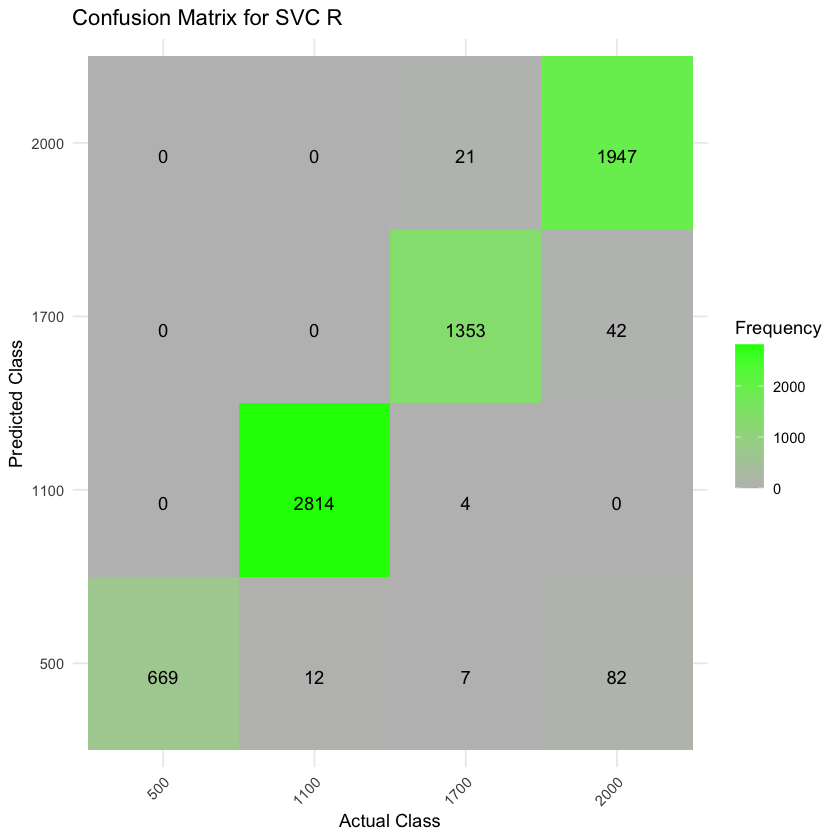

In [6]:
conf_mat <- as.matrix(conf_matrix$table)
conf_data <- as.data.frame(melt(conf_mat))
names(conf_data) <- c("Reference", "Prediction", "Frequency")

custom_labels <- c('500', '1100', '1700', '2000')

conf_data$Reference <- factor(conf_data$Reference, levels = unique(conf_data$Reference), labels = custom_labels)
conf_data$Prediction <- factor(conf_data$Prediction, levels = unique(conf_data$Prediction), labels = custom_labels)

 ggplot(conf_data, aes(x = Reference, y = Prediction, fill = Frequency)) +
    geom_tile() +
    geom_text(aes(label = Frequency), vjust = 1.5, color = "black") +
    scale_fill_gradient(low = "grey", high = "green") +
    labs(title = "Confusion Matrix for SVC R", x = "Actual Class", y = "Predicted Class") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text.y = element_text(angle = 0)) + 
    scale_x_discrete(labels = custom_labels) +
    scale_y_discrete(labels = custom_labels)


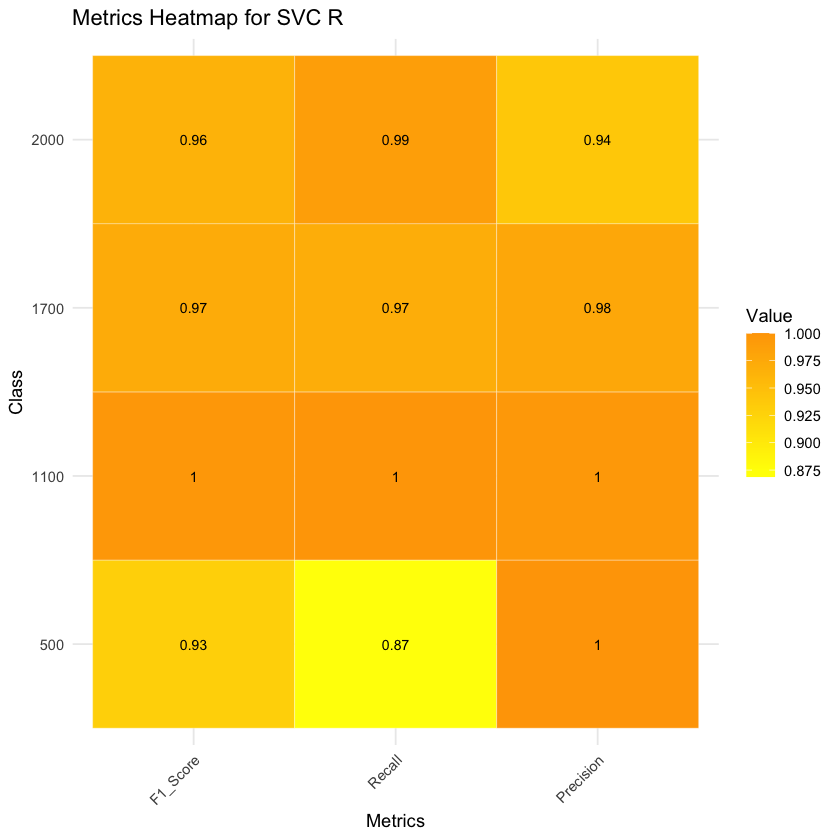

In [7]:
f1 <- cm[["byClass"]][ , "F1"]
recall <- cm[["byClass"]][ , "Recall"]
precision <- cm[["byClass"]][ , "Precision"]

metrics_df <- data.frame(Class = rownames(cm[["byClass"]]), F1_Score = f1, Recall = recall, Precision = precision)

metrics_melted <- melt(metrics_df, id.vars = "Class", variable.name = "Metric", value.name = "Value")

metrics_melted$Class <- factor(metrics_melted$Class, levels = unique(metrics_melted$Class))

custom_labels <- c('500','1100','1700','2000')

ggplot(metrics_melted, aes(x = Metric, y = Class, fill = Value, label = round(Value, 2))) +
  geom_tile(color = "white") +
  geom_text(color = "black", size = 3) +
  scale_fill_gradient(low = "yellow", high = "orange") +
  labs(title = "Metrics Heatmap for SVC R", x = "Metrics", y = "Class") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  scale_y_discrete(labels = custom_labels) 